In [89]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from utils import name_generator
import scipy.stats as stats

In [78]:
def plot_all_individual_judgements(expert_groups):
    """
    Plots the individual judgements of multiple expert groups on the same histogram for each proposition.

    Parameters:
    - expert_groups: A list of Expert_Group instances.
    """
    if not expert_groups:
        print("No expert groups provided.")
        return
    
    # Define a list of colors or use a colormap
    colors = sns.color_palette('hsv', len(expert_groups))

    # Assuming all expert groups have the same propositions
    propositions = list(expert_groups[0].propositions)
    n_props = len(propositions)
    plt.figure(figsize=(14, 4 * n_props + 2))

    for i, prop in enumerate(propositions, start=1):
        plt.subplot(n_props, 1, i)
        for idx, expert_group in enumerate(expert_groups):
            # Use the same color for individual judgements and aggregate judgement line of the expert group
            group_color = colors[idx]
            label = f'(Bias: {expert_group.population_bias}, population sd: {expert_group.population_sd:.3f}, sample mean sd: {expert_group.sample_mean_sd:.3f}, sample sd: {expert_group.sample_sd_dict[prop]:.3f})'
            #label = f'{expert_group.name} (Bias: {expert_group.bias}, Consensus: {expert_group.consensus}, Competence: {expert_group.competence})'
            sns.histplot(expert_group.individual_judgements[prop], kde=False, bins='auto', color=group_color, label=label, stat="density")
            plt.axvline(x=expert_group.aggregate_judgements[prop], color=group_color, linestyle='--', label=f'{expert_group.name} aggregate judgement')
        
        # Ideal credence line
        plt.axvline(x=expert_groups[0].ideal_credences[prop], color='black', linestyle='--', label=f'Ideal credence for "{prop}"')
        plt.legend()
        plt.title(f'Individual Judgements Distribution for "{prop}"')
        plt.xlabel('Value')
        plt.xlim(0,1)
        plt.ylim(0,15)
        plt.ylabel('Density')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=2, title='')
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

In [79]:
''' not sure if i need this. 
Might be helpful in simulating how to maximize accuracy. 
Accuracy is a relation between a credence and the truth.

"There are many different measures of accuracy that can be used; in this paper I will be assuming the
most standardly used measure, the Brier score, but as far as I am aware, assuming a different accuracy 
measure would not necessarily impact the argument." - https://link.springer.com/article/10.1007/s11229-020-02849-z
'''
class World():
    '''maps propositions to truth values'''
    def __init__(self) -> None:
        pass

In [87]:
class Ideal_Credences():
    ''' 
    Maps propositions to credences

    truth of a proposition is binary but ideal credence can range from 0 to 1. 
    Ideal credence is the credence that best fulfills epistemic norms given all 
    available evidence (not necessarily accessible to you).

    "I will assume that credences are sharp and
    that the uniqueness thesis is true (Elga 2010; Kopec & Titelbaum 2016). In other
    words, I will assume that for any proposition p and any set of evidence E there is
    only one maximally rational credence that a perfectly rational epistemic agent could
    have, which is a sharp value and not an interval, and any deviation from the unique
    maximally rational credence constitutes a deviation from rationality."
     - https://link.springer.com/article/10.1007/s11229-020-02849-z
    '''
    def __init__(self, propositions: list, seed = None) -> None:
        if seed is not None:
            random.seed(seed)
        self.credence_function = {}
        self.propositions = propositions
        

    def random_generate_ideal_credences(self):
        self.credence_function = {proposition: random.uniform(0, 1) for proposition in self.propositions}
        


In [132]:
class Expert_Group():
    '''
    Experts are represented at the group level, questions of belief merging and aggregation 
    within the group are abstracted. individual experts are simulated for fun.

    Expert groups are static in this model. Their credences do not update

    Expert groups are defined relative to an ideal credence function (since the attribute "bias" is relative to ideal credence)
    '''
    def __init__(self, ideal_credence_obj:Ideal_Credences, name = None, n_experts:int = 1000, population_sd:float = 0.2, population_bias:float = 0.1, population_simulation_n:int = 1000000, plot = False) -> None:
        if name is not None:
            self.name = name
        else:
            self.name = name_generator()
        # simulation settings
        self.n_experts = n_experts
        self.population_simulation_n = population_simulation_n
        # each expert population is defined by two attributes: bias, which is relative to an ideal credence, and population_sd, 
        #which is the standard deviation of the opinions among thepopulation
        self.population_bias = population_bias
        self.population_sd = population_sd
        # get standard deviation of sample mean using central limit theorem
        self.sample_mean_sd = self.population_sd / np.sqrt(self.n_experts)
        # get sample standard deviation

        self.ideal_credences = ideal_credence_obj.credence_function
        self.propositions = list(self.ideal_credences.keys())
        # each expert group has a set of aggregate judgements, which are functions that map credences to propositions
        self.aggregate_judgements = {} 
        # run init methods
        self.simulate_expert_population()
        self.simulate_expert_individual_judgements()
        self.get_aggregate_judgements()
        if plot: 
            self.plot_individual_judgements()
            self.plot_expert_sample_mean_distribution()
    
    def simulate_expert_population(self):
        # note that this is not the actual expert population, but a stand in for an infinite pool of counterfactual experts
        # get population mean judgements
        keys = self.propositions
        values = np.array(list(self.ideal_credences.values()))
        # randomly generate a single sample mean using the sample_mean_sd centered around bias + ideal credence
        self.population_means = {prop:value for prop, value in zip(keys, self.population_bias + values)}
        self.expert_population_judgements = {prop: np.clip(np.random.normal(loc=val, scale=self.population_sd, size=self.population_simulation_n), 0, 1)
                   for prop, val in zip(keys, self.population_means.values())}
    
    def simulate_expert_individual_judgements(self, plot = False):
        # randomly select n_experts_sample experts from self.expert_population_judgements, which is a dictionary of arrays
        self.individual_judgements = {
                                        key: np.random.choice(val, size=self.n_experts, replace=False)
                                        for key, val in self.expert_population_judgements.items()
                                    }
        self.sample_sd_dict = {key: np.std(val) for key, val in self.individual_judgements.items()}
        if plot:
            self.plot_individual_judgements()

    def get_aggregate_judgements(self):
        # for each proposition, get the mean of the sampled expert judgements
        self.aggregate_judgements = {key: np.mean(val) for key, val in self.individual_judgements.items()}

    def plot_individual_judgements(self):
        """
        Plots the samples for each proposition in self.aggregate_judgements.
        Each proposition's samples are plotted as a histogram.
        """
        n_props = len(self.propositions)   
        plt.figure(figsize=(12, 3 * n_props))

        for i, (prop, values) in enumerate(self.individual_judgements.items(), start=1):
            label = f'{self.name} (Bias: {self.population_bias}, population sd: {self.population_sd:.3f}, sample mean sd: {self.sample_mean_sd:.3f}, sample_sd = {self.sample_sd_dict[prop]:.3f})'
            plt.subplot(n_props, 1, i)
            sns.histplot(values, kde=False, bins='auto', color='skyblue', label=label, stat="density")
            plt.axvline(x=self.aggregate_judgements[prop], color='b', linestyle='--', label=f'Aggregate judgement')
            plt.axvline(x=self.ideal_credences[prop], color='black', linestyle='--', label=f'Ideal credence')
            plt.legend()
            plt.title(f'Samples Distribution for {self.name} judgements on "{prop}"')
            plt.xlabel('Value')
            plt.xlim(0,1)
            plt.ylim(0,15)
            plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()

    def plot_expert_sample_mean_distribution(self):
        # plot distribution of expert sample means with means in self.expert_population_judgements
        n_props = len(self.propositions)
        plt.figure(figsize=(12, 3 * n_props))
        for i, prop in enumerate(self.propositions, start=1):
            plt.subplot(n_props, 1, i)
            label = f'{self.name} (Bias: {self.population_bias}, sample mean sd: {self.sample_mean_sd:.3f})'
            mu = self.population_means[prop]
            sigma = self.sample_mean_sd
            x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
            plt.plot(x, stats.norm.pdf(x, mu, sigma),label=label)
            plt.axvline(x=self.ideal_credences[prop], color='black', linestyle='--', label=f'Ideal credence')
            plt.xlim(0,1)
            # plt.ylim(0,15)
            plt.legend()
            plt.title(f'Expert sample mean distribution for "{prop}"')


#### Questions
        '''
        1. should expert group attributes be relativised to single beliefs? if so, 
        it makes it hard to capture how distrust spreads to other propositions.
        2. The truth + bias parameter should determine the aggregate judgement of experts on 
        every single proposition. This seems problematic. shouldn't it vary? But bias on 
        different propositions should have a strong correlation with each other too.
        '''

In [133]:
# maybe not necessary
# agent's belief. this also stores the expert groups relevant for the belief
# class Credence():
#     def __init__(self, proposition, initial_credence = 0.5) -> None:
#         self.content = proposition
#         self.value = initial_credence
#         self.relevant_expert_groups = []

In [134]:
class Bayesian_Agent():
    def __init__(self, ideal_credence_obj: Ideal_Credences) -> None:
        self.credences = {} #keys are propositions, values are Credence objects
        self.expert_group_representations = {}

        self.ideal_credences = ideal_credence_obj.credence_function
        self.propositions = list(self.ideal_credences.keys())
        pass
    
    
    def get_priors(self, randomize_method = 'uniform'): 
        '''Not sure how to do this right. This shouldn't be thought of as just the priors from a blank slate. 
        Rather, this should reflect the credences that result from the agent's lived experiences, etc.'''
        # creates a dictionary for self.credences
        if randomize_method == 'uniform':
            # for each proposition, set the credence to a random number between 0 and 1
            self.credences = {prop: random.uniform(0, 1) for prop in self.propositions}


    def init_expert_group_representations(self):
        '''Not sure how to do this right.'''
        

    def update_expert_group_representations(self, expert_groups: list):
        # updates all expert group representations at once. since, for bayesian agents, order shouldn't matter. even if updates are sequential, they should apply retroactively too. 
        pass
        
    def update_proposition_credence(proposition, evidence, source):
        pass

In [135]:
'''
do i need this?
An accuracy measure A is a function which takes a
credence function c at a world w, and yields as its output a number A(c, w) which
is a measure of the accuracy of the credence function at that world
'''

'\ndo i need this?\nAn accuracy measure A is a function which takes a\ncredence function c at a world w, and yields as its output a number A(c, w) which\nis a measure of the accuracy of the credence function at that world\n'

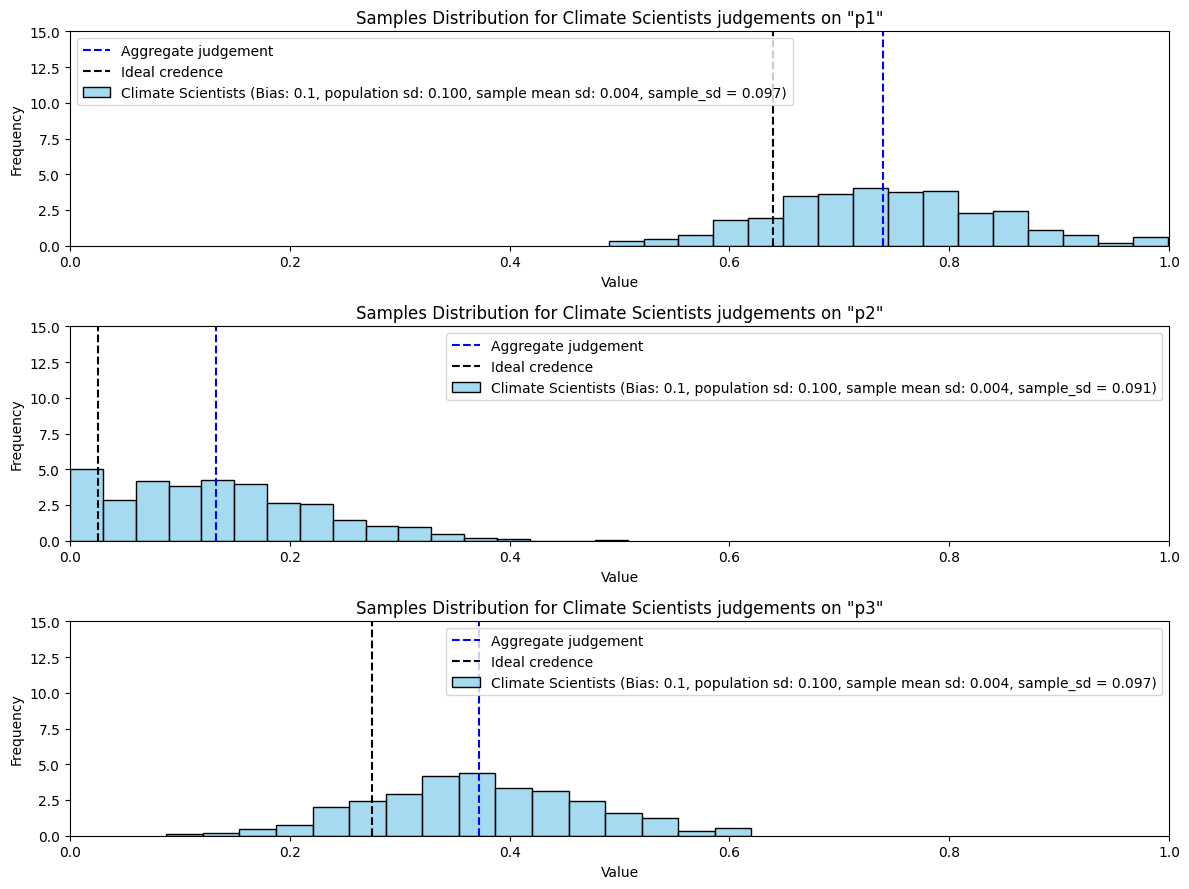

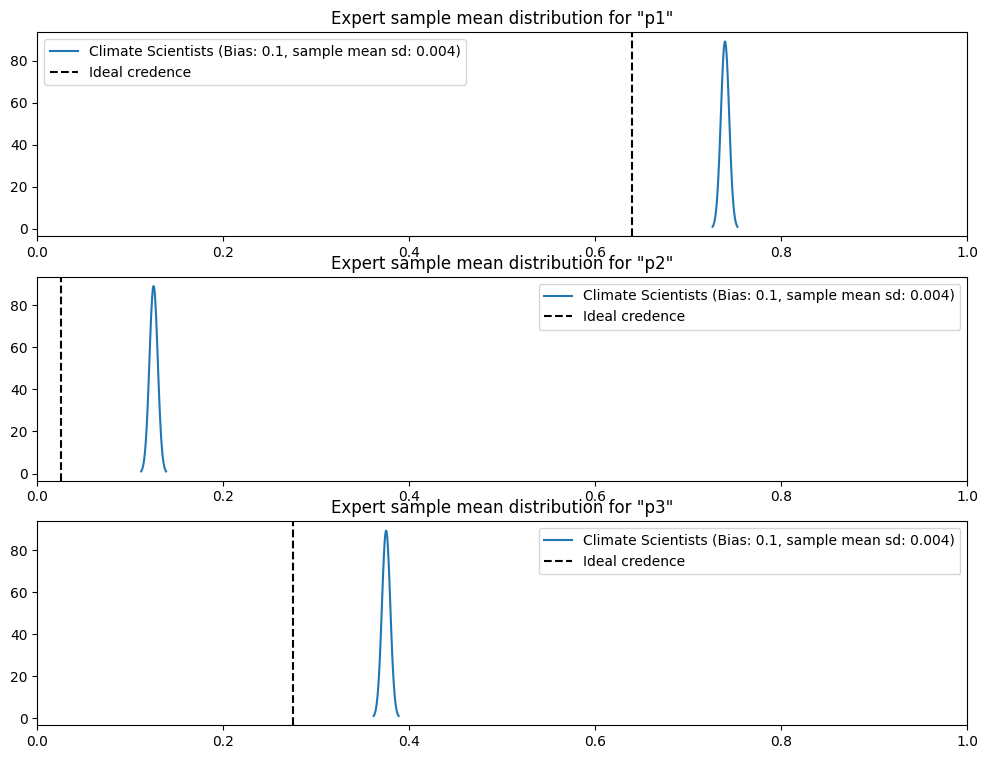

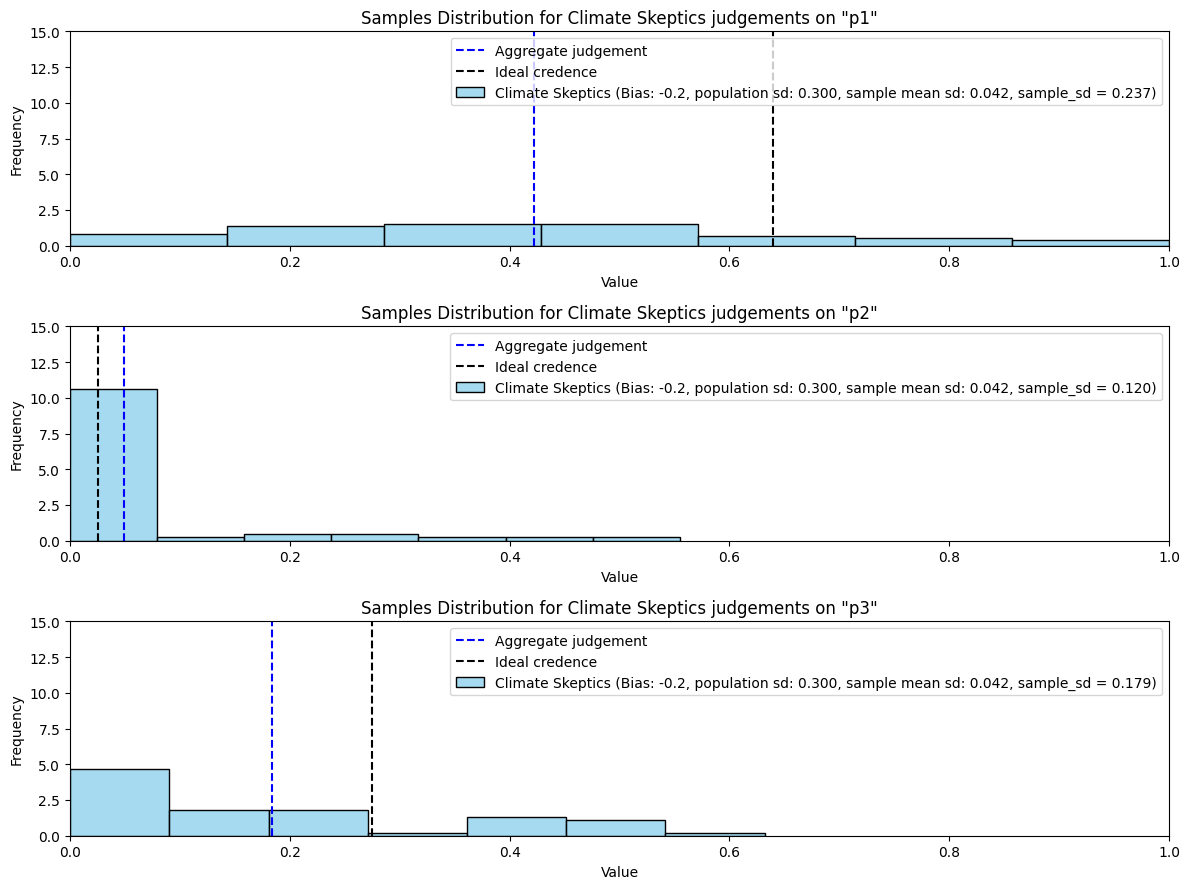

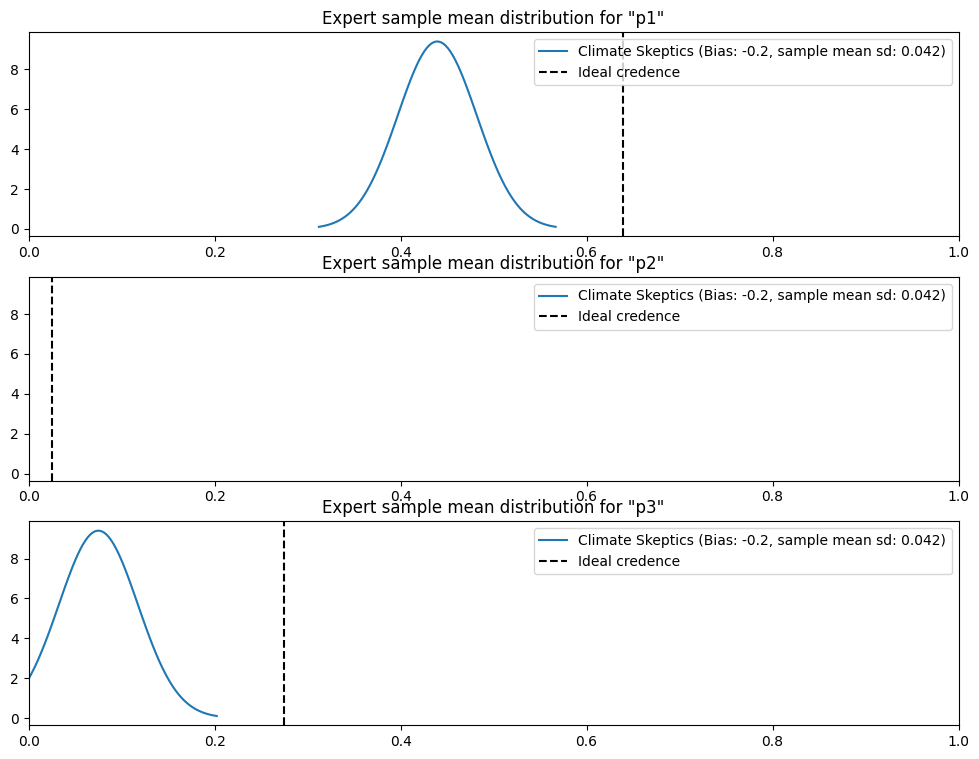

In [137]:
PLOT = True

propositions = ['p1', 
                'p2',
                'p3']
# ideal credence should be unique in each world, w. 
ideal_credence_obj = Ideal_Credences(propositions, seed = 42)
ideal_credence_obj.random_generate_ideal_credences()
climate_scientists = Expert_Group(ideal_credence_obj,name = 'Climate Scientists',population_bias=0.1,population_sd=0.1,n_experts=500, plot = PLOT)
climate_skeptics = Expert_Group(ideal_credence_obj,name = 'Climate Skeptics',population_bias=-0.2,population_sd=0.3,n_experts=50, plot = PLOT)

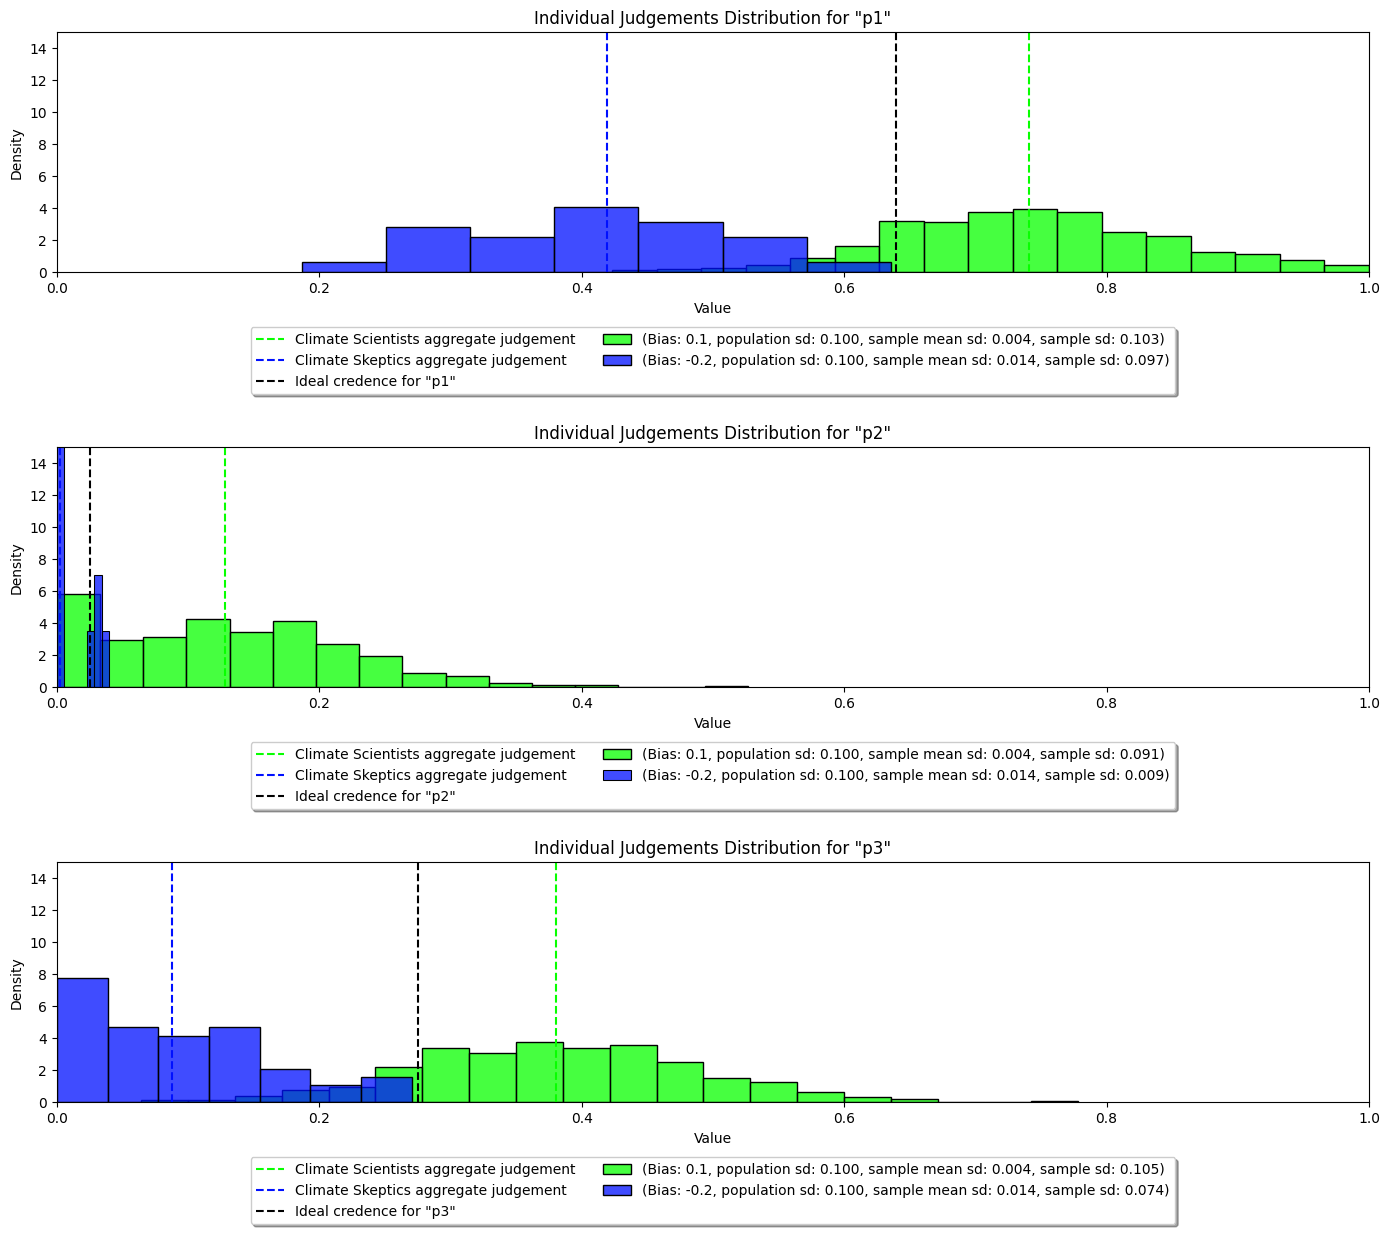

In [88]:
expert_groups = [climate_scientists,climate_skeptics]
plot_all_individual_judgements(expert_groups)